# Google trends vs anomalies in name frequency
This notebook uses the pytrends library, which is not supported by Google. Often, while creating this notebook, Google returned a "too many requests" error, even when making very minor & infrequent requests. So the focus of this notebook is to look at a handful of name frequency anomalies and explore if Google trends might predict those anomalies.

In [1]:
import numpy as np
import pandas as pd

from data_loader import load_names_from_web

import matplotlib.pyplot as plt

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from pytrends.request import TrendReq

from datetime import datetime

import requests

## get SSA name data and find some anomalies that occurred since 2004

In [4]:
dfraw = load_names_from_web(category="national", hide_pre_1937=True)
dfraw.sample(5)

,state,year,name,M/F,count
944361,US,1976,Kathy,M,6
900731,US,1974,Helena,F,193
1185113,US,1945,Vernell,F,125
939293,US,1976,Damian,M,994
1168764,US,1979,Cher,F,24


In [5]:
dfn1 = dfraw[['name', 'M/F', 'count', 'year']].sort_values(['M/F','name','year'])
dfn1.columns=['name', 'gender', 'count', 'year']
dfn1['diff'] = dfn1.groupby(['gender','name'])['count'].diff()
dfn1['accel'] = dfn1.groupby(['gender','name'])['diff'].diff()
dfn1.head(12)

,name,gender,count,year,diff,accel
529547,Aabha,F,7,2011,NaN,NaN
332735,Aabha,F,5,2012,-2.0,NaN
40723,Aabha,F,9,2014,4.0,6.0
110726,Aabha,F,7,2015,-2.0,-6.0
295685,Aabha,F,7,2016,0.0,2.0
2066820,Aabha,F,6,2019,-1.0,-1.0
1780595,Aabha,F,5,2020,-1.0,0.0
1677182,Aabha,F,5,2021,0.0,1.0
1847356,Aabha,F,5,2022,0.0,0.0
1978085,Aabidah,F,5,2018,NaN,NaN


In [6]:
num_previous_years = 10

dfn2 = dfn1.sort_values(by=['name', 'gender', 'year'])

# note: min_periods=10 means that there won;t be calculations if there are not 10 previous years
# note: shift(1) means the current year is not included ion the average and std dev
dfn2['10yr_ave'] = dfn2.groupby(['name','gender'])['count'].transform(lambda x: x.rolling(window=10, min_periods=10).mean().shift(1))
dfn2['10yr_std'] = dfn2.groupby(['name','gender'])['count'].transform(lambda x: x.rolling(window=10, min_periods=10).std().shift(1))
dfn2['10yr_z_score'] = dfn2['diff'] / dfn2['10yr_std']
dfn2.head()

,name,gender,count,year,diff,accel,10yr_ave,10yr_std,10yr_z_score
448288,Aaban,M,5,2007,NaN,NaN,NaN,NaN,NaN
1658424,Aaban,M,6,2009,1.0,NaN,NaN,NaN,NaN
622298,Aaban,M,9,2010,3.0,2.0,NaN,NaN,NaN
542793,Aaban,M,11,2011,2.0,-1.0,NaN,NaN,NaN
342452,Aaban,M,11,2012,0.0,-2.0,NaN,NaN,NaN


In [7]:
# google trends goes back to 2004
dfn3 = dfn2.loc[dfn2['year']>2003]

In [39]:
# get big anomalies: 
#     overall jumps and drops.
#     high z-scores
anomaly_count = 5
min_10yr_ave = 1000 # a name that jumped from 5 to 10 might have a big z-score, but a diff of 5 is not a big deal
min_anomaly_year = 2012 # let's ignore big changes that occured in early Google times.


z1 = dfn3.loc[(dfn3['10yr_ave']>=min_10yr_ave) & (dfn3['year']>=min_anomaly_year)].sort_values(by=['10yr_z_score']).head(anomaly_count)
z1['type']='z-score drop'

z2 = dfn3.copy()
z2.replace([np.inf, -np.inf], np.nan, inplace=True)
z2 = z2[~pd.isnull(z2['10yr_z_score'])]
z2 = z2.loc[(z2['10yr_ave']>=min_10yr_ave) & (z2['year']>=min_anomaly_year)].sort_values(by=['10yr_z_score']).tail(anomaly_count)
z2['type']='z-score jump'

z3 = dfn3.loc[(dfn3['10yr_ave']>=min_10yr_ave) & (dfn3['year']>=min_anomaly_year)].sort_values(by=['diff']).head(anomaly_count)
z3['type']='overall drop'

# z4 = dfn3[~pd.isnull(dfn3['diff'])].sort_values(by=['diff']).tail(anomaly_count)
z4 = dfn3[~pd.isnull(dfn3['diff'])].loc[(dfn3['10yr_ave']>=min_10yr_ave) & (dfn3['year']>=min_anomaly_year)].sort_values(by=['diff']).tail(anomaly_count)
z4['type']='overall jump'

anomalies = pd.concat([z1, z2, z3, z4], axis=0).reset_index()
anomalies

,index,name,gender,count,year,diff,accel,10yr_ave,10yr_std,10yr_z_score,type
0,450642,Allyson,F,1008,2013,-258.0,-311.0,1280.9,41.197222,-6.262558,z-score drop
1,1962662,Julianna,F,1363,2018,-240.0,-237.0,1701.9,56.740051,-4.229816,z-score drop
2,1980604,Charles,M,6653,2018,-529.0,-589.0,7147.8,138.762627,-3.812266,z-score drop
3,1679784,Emmanuel,M,1977,2021,-483.0,-527.0,2512.5,128.139030,-3.769343,z-score drop
4,1849962,Jude,M,2288,2022,-214.0,-281.0,2527.7,63.603022,-3.364620,z-score drop
5,117090,Kameron,M,1506,2015,211.0,138.0,1261.8,45.606530,4.626530,z-score jump
6,2071281,Kyler,M,1606,2019,472.0,410.0,1245.4,90.838318,5.196045,z-score jump
7,335592,Calvin,M,1965,2012,257.0,210.0,1618.3,46.053230,5.580499,z-score jump
8,469825,Lorenzo,M,1516,2013,428.0,372.0,1037.5,73.121284,5.853289,z-score jump
9,1765543,Gianna,F,7890,2020,4471.0,4497.0,3464.2,333.071831,13.423531,z-score jump


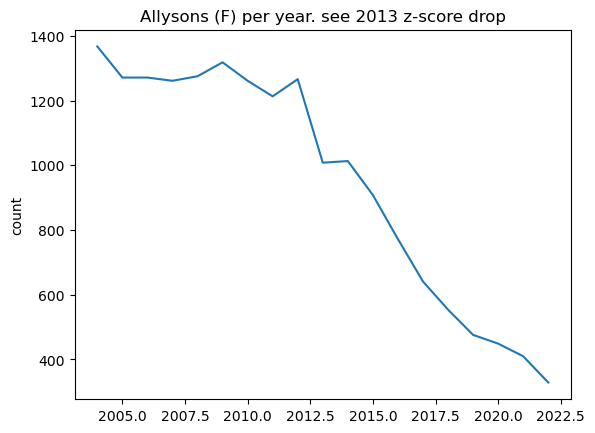

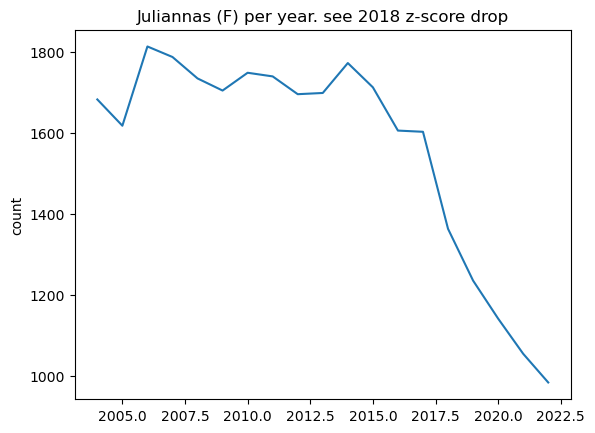

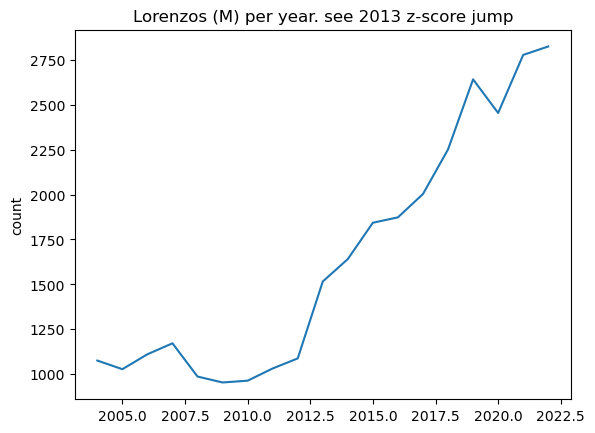

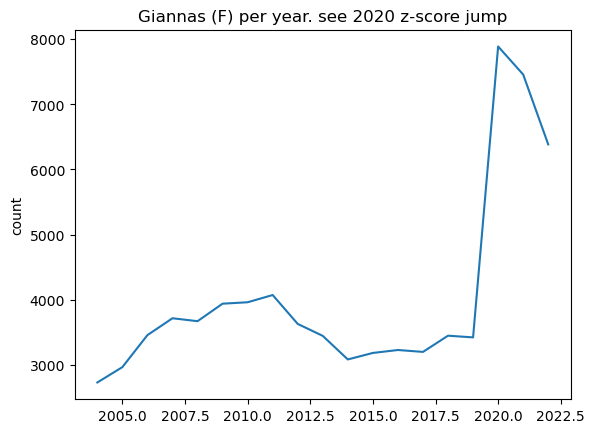

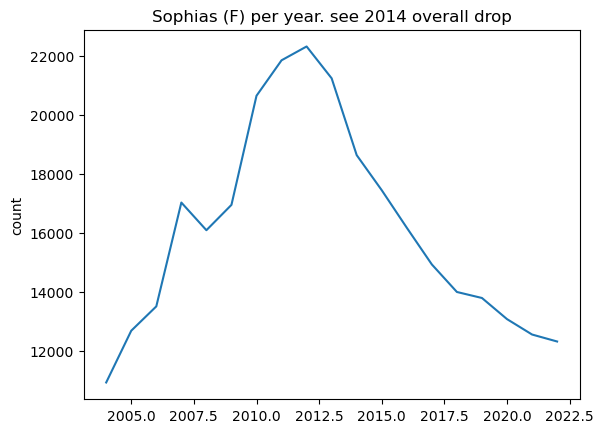

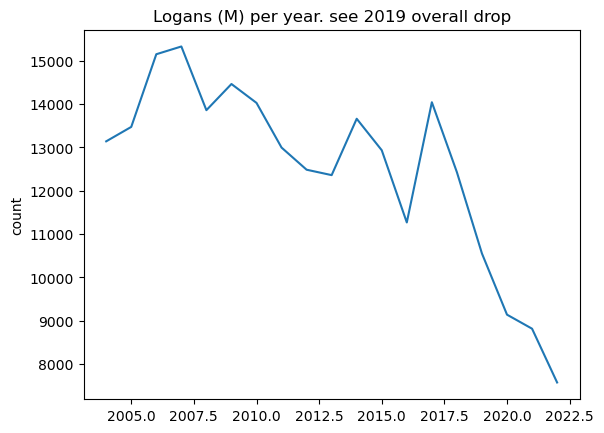

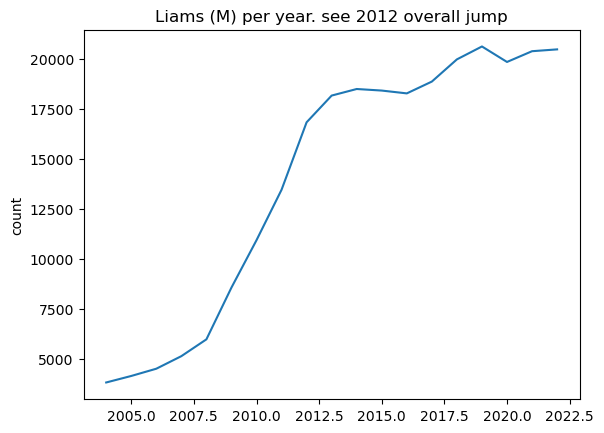

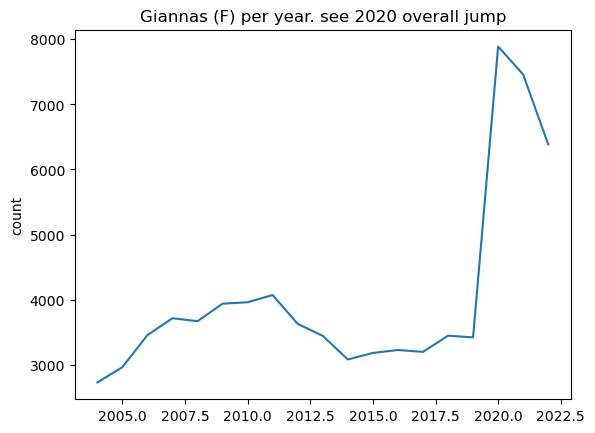

In [20]:
for ind in anomalies.index:
    name = anomalies.name[ind]
    gender = anomalies.gender[ind]
    yr = anomalies.year[ind]
    typ = anomalies.type[ind]
    
    z = dfn3.loc[(dfn3['name']==name) & (dfn3['gender']==gender)].sort_values(['year'])
    plt.plot(z['year'], z['count'])
    plt.ylabel('count')
    plt.title(name + 's (' + gender + ') per year. see ' + str(yr) + ' ' + typ)
    plt.show()    

In [42]:
anomaly_names = list(anomalies['name'])
print(anomaly_names)
# the kw_list maximum is 5. I will manually choose 5 to start, based obn 10yr_ave and z-score
keywords = ['Gianna', 'Logan', 'Charles', 'Ava', 'Harper']
keywords

['Allyson', 'Julianna', 'Charles', 'Emmanuel', 'Jude', 'Kameron', 'Kyler', 'Calvin', 'Lorenzo', 'Gianna', 'Sophia', 'Logan', 'Jayden', 'Ava', 'Ethan', 'Oliver', 'Harper', 'Logan', 'Liam', 'Gianna']


['Gianna', 'Logan', 'Charles', 'Ava', 'Harper']

## get some google trends for those names

see https://colab.research.google.com/github/Tanu-N-Prabhu/Python/blob/master/Google_Trends_API.ipynb

install pytrends: 

https://pypi.org/project/pytrends/

In [19]:
# !pip install pytrends

In [22]:
session = requests.Session()
session.get('https://trends.google.com')
cookies_map = session.cookies.get_dict()
nid_cookie = cookies_map['NID']

In [43]:
# (keywords: see above)
# keywords = anomaly_names
# keywords = ['Jayden']

geo = 'US'
timeframe = '2005-01-01 ' + datetime.now().strftime('%Y-%m-%d')  # just a string represenmting date range
gprop = ''  # Google property: empty means search; could be 'images', 'news', etc.

In [44]:
keywords

['Gianna', 'Logan', 'Charles', 'Ava', 'Harper']

In [54]:
keywords = ['Gianna']

In [55]:
pytrend = TrendReq(requests_args={'headers': {'Cookie': f'NID={nid_cookie}'}})

In [56]:
pytrend.build_payload(kw_list=keywords, geo=geo, timeframe=timeframe, gprop=gprop)

In [57]:
# FYI: Interest by Region (state)
# region_data = pytrend.interest_by_region()
# region_data.head(10)

In [58]:
trends_data = pytrend.interest_over_time()

TooManyRequestsError: The request failed: Google returned a response with code 429

In [ ]:
trends_data.head()

In [75]:
jolette_monthly = pd.read_csv('Jolette.csv', header=1)
jolette_monthly.columns=['month', 'jolette']
jolette_monthly.head()

,month,jolette
0,2004-01,0
1,2004-02,0
2,2004-03,0
3,2004-04,56
4,2004-05,0


In [77]:
# trends_data['year'] = trends_data['date'].dt.to_period('Y')
jolette_monthly['year'] = pd.to_datetime(jolette_monthly['month']).dt.year
jolette_monthly.head()

,month,jolette,year
0,2004-01,0,2004
1,2004-02,0,2004
2,2004-03,0,2004
3,2004-04,56,2004
4,2004-05,0,2004


In [78]:
jolette_yearly = jolette_monthly.groupby('year')['jolette'].sum().reset_index()
jolette_yearly.head()

,year,jolette
0,2004,56
1,2005,297
2,2006,46
3,2007,26
4,2008,50


In [82]:
name = 'Jolette'
gender = 'F'
    
z1 = dfn3.loc[(dfn3['name']==name) & (dfn3['gender']==gender)].sort_values(['year'])
z1.head()

,name,gender,count,year,diff,accel,10yr_ave,10yr_std,10yr_z_score
484603,Jolette,F,258,2005,250.0,248.0,6.8,1.549193,161.374306
351887,Jolette,F,86,2006,-172.0,-422.0,31.6,79.555990,-2.161999
418657,Jolette,F,51,2007,-35.0,137.0,39.6,80.709630,-0.433653
1801353,Jolette,F,36,2008,-15.0,20.0,44.2,79.824530,-0.187912
1633434,Jolette,F,22,2009,-14.0,1.0,47.1,78.843657,-0.177567


In [86]:
z2 = pd.merge(jolette_yearly, z1, on=['year'])
z2.head()

,year,jolette,name,gender,count,diff,accel,10yr_ave,10yr_std,10yr_z_score
0,2005,297,Jolette,F,258,250.0,248.0,6.8,1.549193,161.374306
1,2006,46,Jolette,F,86,-172.0,-422.0,31.6,79.555990,-2.161999
2,2007,26,Jolette,F,51,-35.0,137.0,39.6,80.709630,-0.433653
3,2008,50,Jolette,F,36,-15.0,20.0,44.2,79.824530,-0.187912
4,2009,59,Jolette,F,22,-14.0,1.0,47.1,78.843657,-0.177567


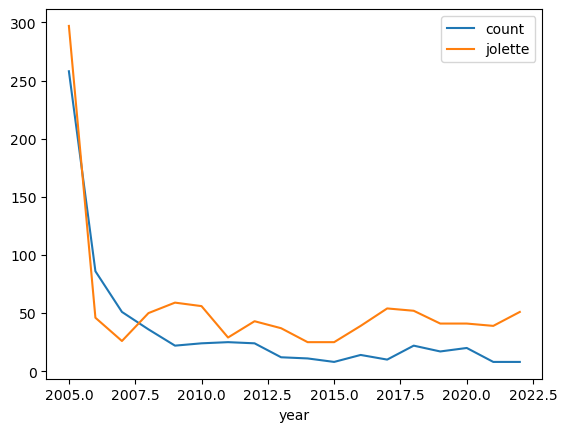

In [89]:
z2.plot(x='year', y=['count', 'jolette'])
plt.show()    